# Early Model Testing

In [33]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import seaborn as sns
import os
import time
from sklearn.ensemble import RandomForestRegressor

### Load dataset

In [34]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [35]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

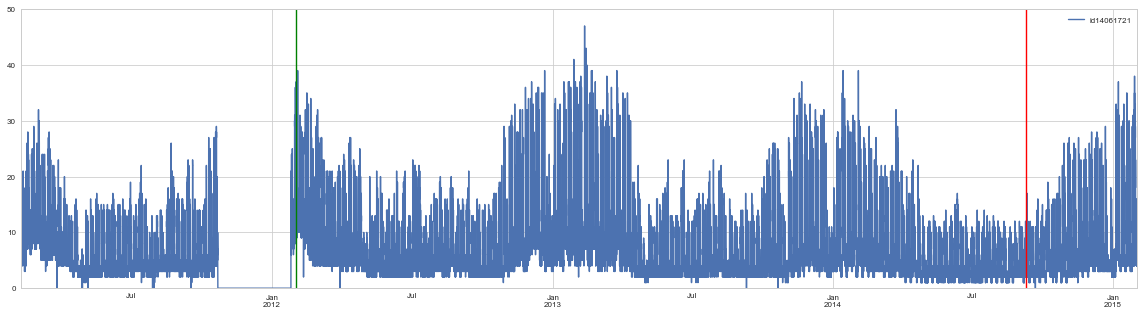

In [36]:
f = original_data[["id14061721"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

## Feature Importances

Mean importances of all sensors

In [37]:
wetaher_current_cols =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_cols =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_cols =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

feature_importances = pd.DataFrame(columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'horizon']))
feature_importances.index.name = "Feature"

In [38]:
sensors_list = list(data)[:30] # Sensor ids (30)

for sensor_name in sensors_list:
    print "Working with sensor: {}".format(sensor_name)
    
    # Create dataframe for specific sensor
    sensor_cols_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
    sensor_data_cols = [col for col in list(data) if col not in sensor_cols_to_drop]
    sensor_data = data[sensor_data_cols]
    
    # Replace 'sensor id' column names with 'measurement'
    sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)
    
    # Prepare columns to shift
    columnsToShift = list(sensor_data)
    shiftedColumns = ["shifted_" + col for col in columnsToShift]
    
    # Prepare datasets
    measurements_cols = [col for col in list(sensor_data) if col.startswith('measurement')]    
    all_cols = measurements_cols + wetaher_current_cols + weather_forecasted_cols + date_time_cols 

    for horizon in range (1,25):
        print "Horizon: {}h".format(horizon)
        
        sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
        sensor_data.dropna(inplace=True)

        training_data = sensor_data[:splitting_time]
        testing_data = sensor_data[splitting_time:]

        model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)

        X_train = training_data[all_cols].values
        y_train = training_data[["shifted_measurement"]].values.ravel()

        X_test = testing_data[all_cols].values
        y_test = testing_data[["shifted_measurement"]].values.ravel()

        start = time.time() # Start measuring time
        model.fit(X_train,y_train)
        runtime = time.time() - start # Calculate runtime

        feature_importances.loc[:,(sensor_name, horizon)] = model.feature_importances_

feature_importances.index = all_cols # Replaces index names
#feature_importances

Working with sensor: id14061671
Horizon: 1h
Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon: 24h
Working with sensor: id14061684
Horizon: 1h
Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon: 24h
Working with sensor: id14061709
Horizon: 1h
Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon:

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
output_file_name = "featureImportanceResultsAll.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances.to_csv(output_file_path)

Compute means of all sensors

In [40]:
feature_importances_all = feature_importances.groupby(level='horizon',axis=1).mean()
feature_importances_all

horizon,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
measurement,0.638686,0.400941,0.205728,0.092816,0.017656,0.013719,0.006302,0.010900,0.005321,0.002872,...,0.003413,0.005844,0.001871,0.002141,0.003069,0.003370,0.003426,0.004891,0.005315,0.257377
measurement_1d,0.002136,0.002465,0.002432,0.003710,0.003535,0.002657,0.002368,0.002322,0.002045,0.001684,...,0.001598,0.001544,0.001574,0.001713,0.001849,0.002145,0.002031,0.002455,0.003585,0.007703
measurement_2d,0.001779,0.003021,0.004426,0.004093,0.004161,0.002910,0.001785,0.001816,0.001998,0.001505,...,0.001699,0.002825,0.001636,0.002990,0.003730,0.007022,0.007628,0.012665,0.022782,0.044156
measurement_1w,0.001743,0.001735,0.001671,0.001840,0.001947,0.001965,0.002189,0.002460,0.002370,0.002222,...,0.001954,0.002497,0.001759,0.001522,0.002434,0.002524,0.001793,0.002060,0.002364,0.006714
measurement_roll_mean_1h,0.088882,0.069965,0.039747,0.028128,0.024999,0.022023,0.034254,0.037488,0.032702,0.035777,...,0.032206,0.029286,0.030013,0.031697,0.035128,0.036323,0.030948,0.034168,0.346840,0.117379
measurement_roll_mean_6h,0.031439,0.033291,0.047767,0.032472,0.028330,0.031242,0.018100,0.011619,0.013760,0.009062,...,0.043668,0.046194,0.056247,0.130199,0.227287,0.341336,0.390868,0.333543,0.039877,0.025781
measurement_roll_mean_d,0.007834,0.033599,0.105564,0.119750,0.120158,0.117672,0.112051,0.096071,0.108715,0.106227,...,0.065514,0.062453,0.053908,0.042098,0.031083,0.028933,0.028927,0.032076,0.032828,0.029892
measurement_roll_mean_w,0.004935,0.008360,0.014319,0.021403,0.028069,0.033801,0.032165,0.032645,0.036558,0.035915,...,0.037521,0.037491,0.033433,0.023215,0.015117,0.012042,0.016262,0.021584,0.025604,0.025543
measurement_roll_mean_m,0.003609,0.005151,0.006775,0.008061,0.008729,0.008604,0.008963,0.008988,0.008668,0.009439,...,0.009207,0.008757,0.009203,0.010307,0.008952,0.009150,0.009460,0.012674,0.014133,0.012691
measurement_roll_min2_d,0.001906,0.008150,0.007957,0.008828,0.007781,0.008239,0.008018,0.007624,0.007956,0.007619,...,0.006521,0.007220,0.008472,0.006984,0.004701,0.002677,0.002136,0.004038,0.002556,0.001524


In [41]:
output_file_name = "featureImportanceResults.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances_all.to_csv(output_file_path)

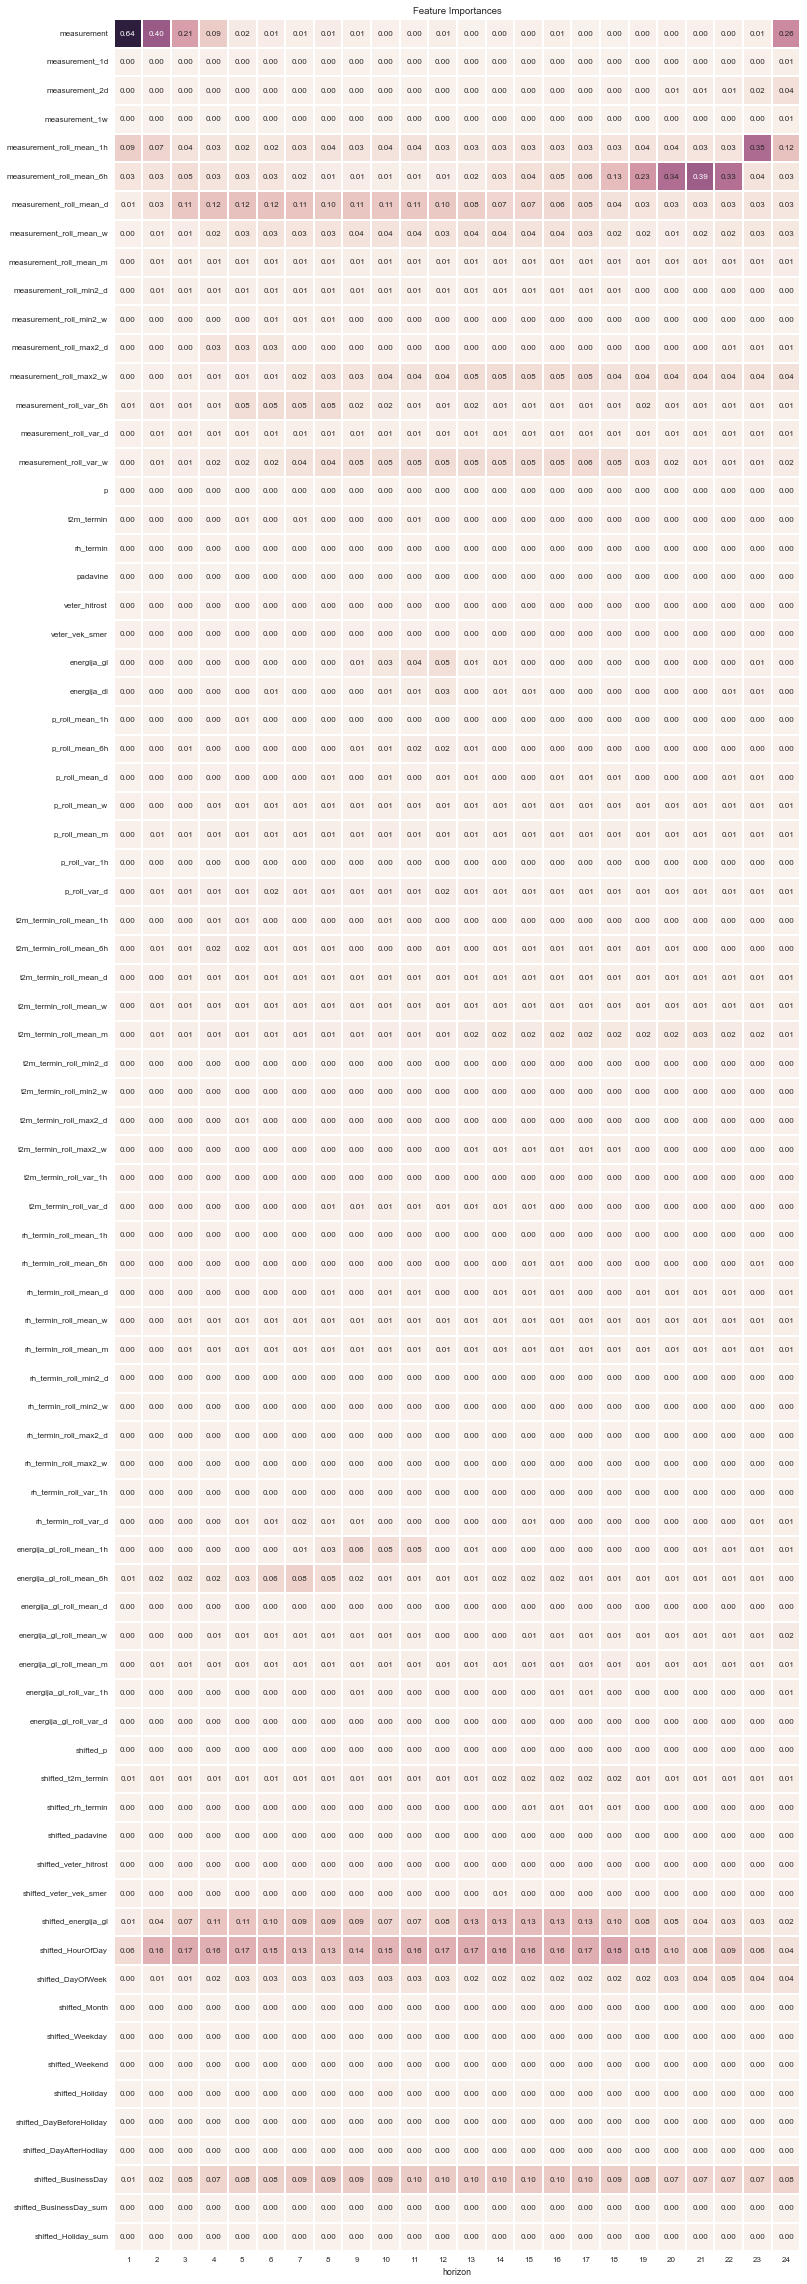

In [42]:
#import seaborn as sns
sns.set(context="paper", font="monospace")
sns.set_style("white")

f, ax = plt.subplots(figsize=(30, 40))
sns.heatmap(feature_importances_all, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances")
plt.savefig("./figures/featureImportanceAll.pdf")
plt.savefig("./figures/featureImportanceAll.png", dpi=300)

## Top 20 Features of All Time

In [43]:
feature_importances_all_mean = feature_importances_all.mean(axis=1)
feature_importances_all_mean.sort(ascending=False, inplace=True)
feature_importances_all_mean[:20]

shifted_HourOfDay           0.136186
measurement_roll_mean_6h    0.081726
shifted_energija_gl         0.081388
shifted_BusinessDay         0.079308
measurement                 0.070958
measurement_roll_mean_d     0.070777
measurement_roll_mean_1h    0.052622
measurement_roll_var_w      0.032752
measurement_roll_max2_w     0.032554
measurement_roll_mean_w     0.026966
shifted_DayOfWeek           0.025331
energija_gl_roll_mean_6h    0.019752
measurement_roll_var_6h     0.017765
t2m_termin_roll_mean_m      0.015023
energija_gl_roll_mean_1h    0.011689
shifted_t2m_termin          0.011262
p_roll_var_d                0.009268
measurement_roll_mean_m     0.009040
energija_gl_roll_mean_m     0.008347
energija_gl                 0.007809
dtype: float64

Replace index names

In [44]:
top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]
top20 = feature_importances_all.ix[top20_indices]
#top20

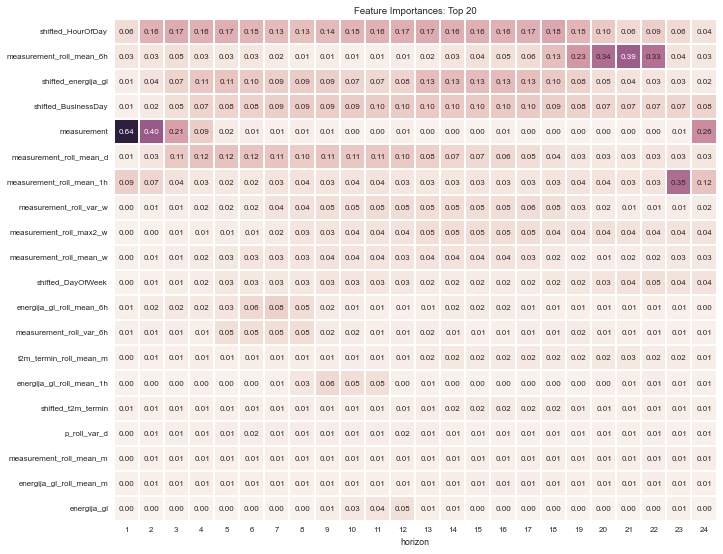

In [45]:
#top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(top20, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances: Top 20")
plt.tight_layout()
plt.savefig("./figures/featureImportanceTop20.pdf")
plt.savefig("./figures/featureImportanceTop20.png", dpi=300)

In [51]:
top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]
top20 = feature_importances_all.ix[top20_indices]
"""
new_index_names = ["measurement_MA_d", "measurement_MA_6h", "hour_of_day", "measurement_minus_1d",
                   "forecasted_global_radiation", 
                   "measurement_MA_h", "measurement_VAR_d", "measurement_VAR_6h", "global_radiation_MA_6h", 
                   "measurement_MIN_d", "business_day", "measurement_MIN_d", "gl_radiation_MA_h", "global_radiation", 
                   "day_of_week", "diffusive_radiation", "forecasted_temperature", "measurement_MA_w", "temperature_MA_6h", 
                   "measurement_MA_m"]
"""
new_index_names = ["hour_of_day", "measurement_MA_6h", "forecasted_global_radiation", "business_day", "measurement",
                   "measurement_MA_d", "measurement_MA_h", "measurement_VAR_w", "measurement_MAX_w", "measurement_MA_w",
                   "day_of_week", "global_radiation_MA_6h", "measurement_VAR_6h", "temperature_MA_m", "global_radiation_MA_h",
                   "forecasted_temperature", "preassure_VAR_d", "measurement_MA_m", "global_radiation_MA_m", "global_radiation"]
top20.index=new_index_names
top20

horizon,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
hour_of_day,0.055134,0.160568,0.174956,0.163152,0.165340,0.150325,0.133812,0.126660,0.137252,0.153843,...,0.164035,0.159223,0.167722,0.184767,0.149898,0.103402,0.060225,0.090973,0.061050,0.041423
measurement_MA_6h,0.031439,0.033291,0.047767,0.032472,0.028330,0.031242,0.018100,0.011619,0.013760,0.009062,...,0.043668,0.046194,0.056247,0.130199,0.227287,0.341336,0.390868,0.333543,0.039877,0.025781
forecasted_global_radiation,0.014119,0.038565,0.074401,0.110838,0.113772,0.099695,0.090592,0.094805,0.091129,0.072069,...,0.134681,0.133667,0.127179,0.102547,0.081827,0.048021,0.036835,0.033185,0.027451,0.017748
business_day,0.006607,0.021009,0.048260,0.073926,0.077948,0.082316,0.090424,0.094826,0.093182,0.093977,...,0.100990,0.101339,0.099675,0.089060,0.080000,0.069198,0.067601,0.067919,0.072621,0.077351
measurement,0.638686,0.400941,0.205728,0.092816,0.017656,0.013719,0.006302,0.010900,0.005321,0.002872,...,0.003413,0.005844,0.001871,0.002141,0.003069,0.003370,0.003426,0.004891,0.005315,0.257377
measurement_MA_d,0.007834,0.033599,0.105564,0.119750,0.120158,0.117672,0.112051,0.096071,0.108715,0.106227,...,0.065514,0.062453,0.053908,0.042098,0.031083,0.028933,0.028927,0.032076,0.032828,0.029892
measurement_MA_h,0.088882,0.069965,0.039747,0.028128,0.024999,0.022023,0.034254,0.037488,0.032702,0.035777,...,0.032206,0.029286,0.030013,0.031697,0.035128,0.036323,0.030948,0.034168,0.346840,0.117379
measurement_VAR_w,0.004202,0.008014,0.014105,0.015669,0.017685,0.020490,0.040908,0.043778,0.046784,0.045613,...,0.051829,0.053638,0.055157,0.046900,0.030309,0.018493,0.014894,0.013390,0.014252,0.016618
measurement_MAX_w,0.002149,0.003847,0.007212,0.010581,0.012319,0.012710,0.021002,0.031900,0.033840,0.036001,...,0.052274,0.051983,0.052550,0.038772,0.039944,0.044141,0.039028,0.036184,0.037698,0.040092
measurement_MA_w,0.004935,0.008360,0.014319,0.021403,0.028069,0.033801,0.032165,0.032645,0.036558,0.035915,...,0.037521,0.037491,0.033433,0.023215,0.015117,0.012042,0.016262,0.021584,0.025604,0.025543


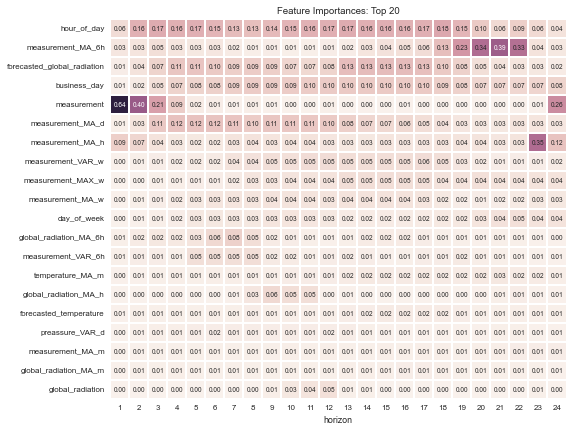

In [57]:
#top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]

f, ax = plt.subplots(figsize=(8, 6.5))
sns.heatmap(top20, square=True, annot=True, annot_kws={"size": 6.5}, fmt=".2f", cbar=False)
plt.title("Feature Importances: Top 20")
plt.tight_layout()
plt.savefig("./figures/featureImportanceTop20.pdf")
plt.savefig("./figures/featureImportanceTop20.png", dpi=300)

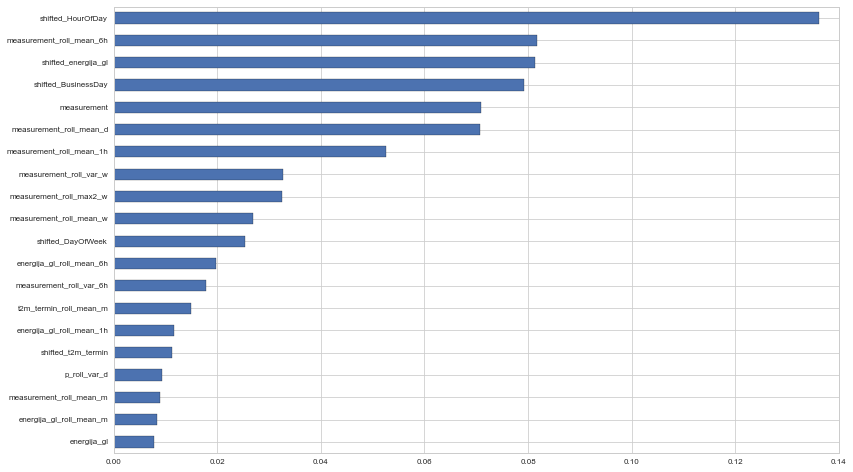

In [53]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

ax = feature_importances_all_mean[:20][::-1].plot(kind='barh', figsize=(13,8))
sns.set_style("whitegrid")
    
plt.savefig("./figures/listOfTop20Features.png", dpi=300)

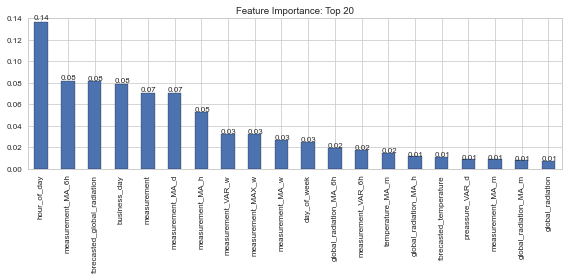

In [59]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#ax = feature_importances_all_mean[:20].plot(kind='bar', figsize=(12,5), title="Feature Importance: Top 20")
ax = top20.mean(axis=1).plot(kind='bar', figsize=(8,4), title="Feature Importance: Top 20")
sns.set_style("whitegrid")
for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x() , p.get_height() * 1.02), fontsize=8)
plt.tight_layout()
plt.savefig("./figures/listOfTop20Features.png", dpi=300)